# **Test A/B*


## **Descripción del ejercicio**

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

### Descripción técnica

- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000

Descarga los datos de la prueba, comprueba si se ha realizado correctamente y analiza los resultados.

Data
- `ab_project_marketing_events_us.csv`: el calendario de eventos de marketing para 2020
- `final_ab_new_users_upd_us.csv`: todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
- `final_ab_events_upd_us.csv`: todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
- `final_ab_participants_upd_us.csv`: tabla con los datos de los participantes de la prueba

Estructura `ab_project_marketing_events_us.csv`:

- `name`: el nombre del evento de marketing
- `regions`: regiones donde se llevará a cabo la campaña publicitaria
- `start_dt`: fecha de inicio de la campaña
- `finish_dt`: fecha de finalización de la campaña

Estructura `final_ab_new_users_upd_us.csv`:

- `user_id`
- `first_date`: fecha de inscripción
- `region`
- `device`: dispositivo utilizado para la inscripción

Estructura `final_ab_events_upd_us.csv`:

- `user_id`
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

Estructura `final_ab_participants_upd_us.csv`:

- `user_id`
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenecía el usuario

### 1. Instrucciones para completar la tarea

- Describe los objetivos del estudio.
- Explora los datos:
    - ¿Es necesario convertir los tipos?
    - ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?


In [2]:
# Importando Librerias

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Cargar los datasets
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

In [3]:
# Verificar estructura y tipos de datos
print("=== MARKETING EVENTS ===")
marketing_events.info()

=== MARKETING EVENTS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
print("\n=== NEW USERS ===")
new_users.info()


=== NEW USERS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [5]:
print("=== EVENTS ===")
events.info()


=== EVENTS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [6]:
print("\n=== PARTICIPANTS ===")
participants.info()


=== PARTICIPANTS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


<div class="alert alert-block alert-success">
<b>Comentario del revisor:</b> <a class="tocSkip"></a>
    
Has realizado un excelente trabajo al importar los datos y las bibliotecas necesarias.

</div>

In [7]:
# Convertir fechas a datetime
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

In [8]:
# Asegurar que user_id sea string en todos los datasets
new_users['user_id'] = new_users['user_id'].astype(str)
events['user_id'] = events['user_id'].astype(str)
participants['user_id'] = participants['user_id'].astype(str)
marketing_events['name'] = marketing_events['name'].astype(str)  

# Convertir 'details' a numérico (solo tiene valor en compras)
events['details'] = pd.to_numeric(events['details'], errors='coerce')

In [9]:
print("\n=== NEW USERS ===")
new_users.info()


=== NEW USERS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [10]:
print("\n=== EVENTS ===")
events.info()


=== EVENTS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


In [11]:
print("\n=== PARTICIPANTS ===")
participants.info()


=== PARTICIPANTS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [12]:
print("=== MARKETING EVENTS ===")
marketing_events.info()

=== MARKETING EVENTS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


### **Conclusion:**

La normalización de tipos de datos es un paso esencial de la limpieza, ya que previene inconsistencias y asegura la fiabilidad de los resultados en el análisis A/B.
La conversión de tipos asegura que las columnas clave —como las fechas y los identificadores de usuario— tengan un formato uniforme y compatible entre los distintos datasets. En este caso, las variables de tipo fecha (first_date, event_dt, start_dt, finish_dt) deben convertirse a datetime para permitir filtros y comparaciones temporales precisas. Asimismo, los campos user_id deben unificarse como cadenas de texto (string, object) para evitar errores al combinar tablas y garantizar la correcta identificación de cada usuario.

In [13]:

# Valores ausentes
print("Valores ausentes por dataset:\n")

print("\nNEW USERS:")
print(new_users.isna().sum())
print("\nEVENTS:")
print(events.isna().sum())
print("\nPARTICIPANTS:")

print(participants.isna().sum())

print("\nMARKETING EVENTS:")
print(marketing_events.isna().sum())


Valores ausentes por dataset:


NEW USERS:
user_id       0
first_date    0
region        0
device        0
dtype: int64

EVENTS:
user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

PARTICIPANTS:
user_id    0
group      0
ab_test    0
dtype: int64

MARKETING EVENTS:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


In [14]:

# Duplicados 
print("Duplicados por dataset:\n")

print("Duplicados en NEW USERS:", new_users.duplicated().sum())
print("Duplicados en EVENTS:", events.duplicated().sum())
print("Duplicados en PARTICIPANTS:", participants.duplicated().sum())
print("Duplicados en MARKETING EVENTS:", marketing_events.duplicated().sum())


Duplicados por dataset:

Duplicados en NEW USERS: 0
Duplicados en EVENTS: 0
Duplicados en PARTICIPANTS: 0
Duplicados en MARKETING EVENTS: 0


<div class="alert alert-block alert-danger">
    <b>Comentario del revisor:</b> <a class="tocSkip"></a>
    
Excelente trabajo,  solamente antes de proceder con el análisi debemos de realizar los siguientes filtros que nos mencionan en el proyecto:
    
    - verificar que las fechas de aplicación corresponden con lo que indica el ejercicio (fechas entre 2020-12-07 y 2021-01-01)
    - Verificar que consideramos los primeros 14 días desde que se registraron los usuarios
    - Verificar que el país de aplicación de EU
   

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Gran trabajo con el ajuste!

In [15]:
# 1. Verificar que las fechas de aplicación corresponden con lo que indica el ejercicio (fechas entre 2020-12-07 y 2021-01-01)

# Verificar rango de fechas en cada dataset
print("=== Rango de fechas por dataset ===\n")

print("NEW USERS:")
print("Mínima:", new_users['first_date'].min())
print("Máxima:", new_users['first_date'].max())

print("\nEVENTS:")
print("Mínima:", events['event_dt'].min())
print("Máxima:", events['event_dt'].max())

print("\nMARKETING EVENTS:")
print("Mínima:", marketing_events['start_dt'].min())
print("Máxima:", marketing_events['finish_dt'].max())


=== Rango de fechas por dataset ===

NEW USERS:
Mínima: 2020-12-07 00:00:00
Máxima: 2020-12-23 00:00:00

EVENTS:
Mínima: 2020-12-07 00:00:33
Máxima: 2020-12-30 23:36:33

MARKETING EVENTS:
Mínima: 2020-01-25 00:00:00
Máxima: 2021-01-07 00:00:00


In [16]:
# Verificar si hay usuarios o eventos fuera del rango oficial de la prueba
inicio_prueba = pd.to_datetime("2020-12-07")
fin_prueba = pd.to_datetime("2021-01-01")

usuarios_fuera_rango = new_users[
    (new_users['first_date'] < inicio_prueba) | (new_users['first_date'] > fin_prueba)
]

eventos_fuera_rango = events[
    (events['event_dt'] < inicio_prueba) | (events['event_dt'] > fin_prueba)
]

print(f"\nUsuarios fuera del rango de registro: {len(usuarios_fuera_rango)}")
print(f"Eventos fuera del rango del experimento: {len(eventos_fuera_rango)}")


Usuarios fuera del rango de registro: 0
Eventos fuera del rango del experimento: 0


**El análisis confirma que las fechas de registro y actividad de los usuarios coinciden con el periodo establecido para la prueba A/B.**

In [17]:
#  Verificar que consideramos los primeros 14 días desde que se registraron los usuarios

# Filtrar eventos que ocurren dentro de los primeros 14 días desde el registro de cada usuario
# Combinar eventos con la fecha de registro del usuario
events_merged = events.merge(new_users[['user_id', 'first_date']], on='user_id', how='left')

# Calcular la diferencia en días entre el evento y la fecha de registro
events_merged['days_since_signup'] = (events_merged['event_dt'] - events_merged['first_date']).dt.days

# Filtrar solo eventos ocurridos dentro de los primeros 14 días
events_14d = events_merged[events_merged['days_since_signup'].between(0, 14)]

# Mostrar resultados
print(f"Eventos totales antes del filtro: {len(events)}")
print(f"Eventos dentro de los primeros 14 días: {len(events_14d)}")
print(f"Eventos excluidos (fuera del rango de 14 días): {len(events) - len(events_14d)}")

Eventos totales antes del filtro: 423761
Eventos dentro de los primeros 14 días: 410214
Eventos excluidos (fuera del rango de 14 días): 13547


**Solo 13,547 eventos quedaron fuera de ese rango y fueron excluidos del análisis, ya que corresponden a interacciones tardías que no forman parte del objetivo de la prueba.**

In [19]:
# Verificar que el país de aplicación de EU

# Filtrar solo usuarios de la región EU
new_users_eu = new_users[new_users['region'] == 'EU']

# Mantener solo los participantes de la región EU en la prueba A/B
participants_eu = participants.merge(new_users_eu[['user_id']], on='user_id', how='inner')

# Filtrar eventos para esos usuarios
events_14d_eu = events_14d[events_14d['user_id'].isin(participants_eu['user_id'])]

print(f"Usuarios totales antes del filtro: {len(new_users)}")
print(f"Usuarios de la región EU: {len(new_users_eu)}")
print(f"Participantes en la prueba (EU): {len(participants_eu)}")
print(f"Eventos dentro de los primeros 14 días (EU): {len(events_14d_eu)}")

Usuarios totales antes del filtro: 58703
Usuarios de la región EU: 43396
Participantes en la prueba (EU): 14331
Eventos dentro de los primeros 14 días (EU): 93009


**Del total de 58,703 usuarios registrados, 43,396 pertenecen a la región de la Unión Europea (EU), que es la población objetivo del experimento.
Tras aplicar el filtro geográfico, se identificaron 14,331 participantes válidos en la prueba A/B y un total de 93,009 eventos dentro de los primeros 14 días posteriores al registro.
Estos resultados confirman que el análisis se está realizando exclusivamente sobre la muestra de usuarios europeos, tal como establecen las especificaciones técnicas del experimento, garantizando así la validez regional de los resultados y evitando sesgos derivados de otras zonas geográficas.** 

### **Conclusion:**

No se observan valores ausentes y duplicados significativos en los datasets, lo que indica una buena calidad de registro y permite continuar con el análisis sin pérdidas relevantes de información.

## 2. Lleva a cabo el análisis exploratorio de datos:

 - Estudia la conversión en las diferentes etapas del embudo.
 - ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

In [18]:
# Filtramos solo los usuarios que participaron en la prueba
ab_events = events.merge(participants, on='user_id', how='inner')

# Comprobamos los tipos de eventos
print("Tipos de eventos registrados:\n", ab_events['event_name'].value_counts())

Tipos de eventos registrados:
 login           44705
product_page    28961
purchase        14854
product_cart    14318
Name: event_name, dtype: int64


In [19]:
#⃣ Análisis del embudo de conversión 

# Definir el orden del embudo
funnel_stages = ['product_page', 'product_cart', 'purchase']

# Calcular cuántos usuarios realizaron cada evento por grupo
funnel = (
    ab_events.groupby(['group', 'event_name'])['user_id']
    .nunique()
    .reset_index()
    .pivot(index='group', columns='event_name', values='user_id')
    .fillna(0)
)

# Calcular la conversión porcentual en cada etapa
funnel['view_to_cart_%'] = funnel['product_cart'] / funnel['product_page'] * 100
funnel['cart_to_purchase_%'] = funnel['purchase'] / funnel['product_cart'] * 100
funnel['overall_conversion_%'] = funnel['purchase'] / funnel['product_page'] * 100

print("\nEmbudo de conversión por grupo:")
print(funnel)


Embudo de conversión por grupo:
event_name  login  product_cart  product_page  purchase  view_to_cart_%  \
group                                                                     
A            7873          2483          5208      2682       47.676651   
B            6204          2037          3986      2008       51.103864   

event_name  cart_to_purchase_%  overall_conversion_%  
group                                                 
A                   108.014499             51.497696  
B                    98.576338             50.376317  


In [20]:
# Distribución de eventos por usuario 

# Número de eventos por usuario en cada grupo
user_event_counts = (
    ab_events.groupby(['group', 'user_id'])['event_name']
    .count()
    .reset_index(name='event_count')
)

# Estadísticas descriptivas
print("Distribución del número de eventos por usuario:")
print(user_event_counts.groupby('group')['event_count'].describe())

Distribución del número de eventos por usuario:
        count     mean       std  min  25%  50%  75%   max
group                                                     
A      7874.0  7.45555  4.475159  1.0  4.0  6.0  9.0  40.0
B      6205.0  7.11249  4.246201  1.0  4.0  6.0  9.0  36.0


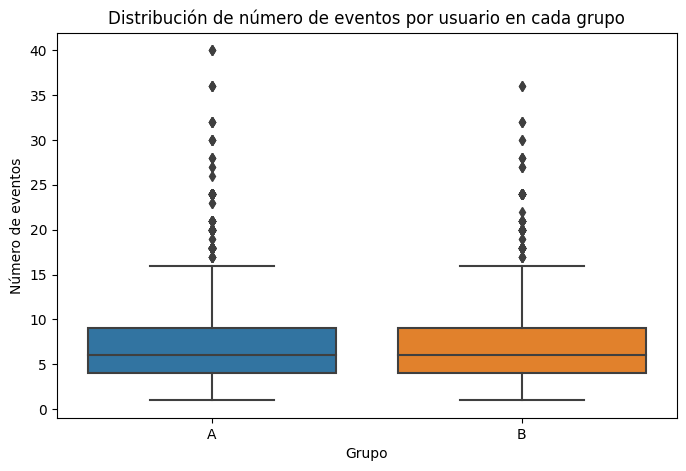

In [21]:
# Grafica de caja

plt.figure(figsize=(8,5))
sns.boxplot(data=user_event_counts, x='group', y='event_count')
plt.title('Distribución de número de eventos por usuario en cada grupo')
plt.xlabel('Grupo')
plt.ylabel('Número de eventos')
plt.show()

### **Conclusión:**

El análisis exploratorio permite comprender el comportamiento de los usuarios en cada fase del embudo de conversión.

**En este estudio:**

- Se observa la progresión natural del embudo desde la visita al producto (product_page) hasta la compra (purchase), evaluando las conversiones parciales y totales para los grupos A y B.

- El cálculo de la distribución de eventos por usuario permite verificar que ambos grupos interactuaron con la plataforma de forma similar, asegurando la comparabilidad estadística entre las muestras.


### - **¿Hay usuarios que están presentes en ambas muestras?**

In [22]:
# Verificar si hay usuarios presentes en ambos grupos

# Crear conjuntos de usuarios por grupo
grupo_a = set(participants[participants['group'] == 'A']['user_id'])
grupo_b = set(participants[participants['group'] == 'B']['user_id'])

# Calcular la intersección
usuarios_en_ambos = grupo_a.intersection(grupo_b)

# Resultados
print("Número de usuarios en el grupo A:", len(grupo_a))
print("Número de usuarios en el grupo B:", len(grupo_b))
print("Usuarios presentes en ambos grupos:", len(usuarios_en_ambos))

# Si quieres ver quiénes son (opcional):
if len(usuarios_en_ambos) > 0:
    print("Ejemplo de IDs duplicados:", list(usuarios_en_ambos)[:10])

Número de usuarios en el grupo A: 7874
Número de usuarios en el grupo B: 6205
Usuarios presentes en ambos grupos: 441
Ejemplo de IDs duplicados: ['4DAD6F609E7D7328', '495E506B3D29645B', '51DA2C882D0D7508', 'A800CDEA85871EEF', '48CFE37563932DC2', 'DF72BA6A526F714F', '0BA00E790AA510C1', '2170CB76798D36EE', '3FC3BE7BAA35F33F', '993BDE69A0DE0391']


In [23]:
# Asignar usuarios duplicados al primer grupo detectado 

participants_sorted = participants.sort_values(by=['user_id', 'group'])
participants_clean = participants_sorted.drop_duplicates(subset='user_id', keep='first')

# Verificar resultado
print("Participantes antes de limpiar:", participants.shape[0])
print("Participantes después de limpiar:", participants_clean.shape[0])
print("Duplicados eliminados:", participants.shape[0] - participants_clean.shape[0])

Participantes antes de limpiar: 14525
Participantes después de limpiar: 13638
Duplicados eliminados: 887


### **Conclusión:**

El análisis revela que existen 441 usuarios presentes simultáneamente en los grupos A y B, de un total de 14 079 participantes. Esta superposición representa un problema de integridad en la segmentación del experimento, ya que los grupos deberían ser mutuamente excluyentes para garantizar la independencia de las muestras.

La presencia de estos usuarios en ambos grupos puede distorsionar las métricas de conversión y sesgar los resultados del test A/B. Realice el siguiente cambio, elimine a los usuarios duplicados, asigne de manera consistente a un solo grupo para asegurar la validez estadística de la prueba.

Ahora el resultado indica que 887 registros fueron eliminados del conjunto de participantes. Esto sucede porque algunos usuarios aparecían más de una vez en el archivo —no solo los 441 usuarios que estaban en ambos grupos (A y B), sino también casos en los que un mismo usuario pudo haber sido registrado repetidamente dentro del mismo grupo.

Además de la duplicación entre grupos, también existían duplicados internos (registros repetidos con el mismo user_id y grupo).
La limpieza eliminó todos estos casos, dejando una base con 13 638 participantes únicos, garantizando que cada usuario pertenezca una sola vez a un único grupo de prueba, lo cual es esencial para la validez estadística del análisis A/B.


### - **¿Cómo se distribuye el número de eventos entre los días?**

In [25]:
# Agrupar los eventos por fecha
eventos_por_dia = events.groupby(events['event_dt'].dt.date).size().reset_index(name='event_count')

# Visualizar los primeros registros
eventos_por_dia.head(30)

,event_dt,event_count
0,2020-12-07,11385
1,2020-12-08,12547
2,2020-12-09,12122
3,2020-12-10,14077
4,2020-12-11,13864
5,2020-12-12,17634
6,2020-12-13,20985
7,2020-12-14,26184
8,2020-12-15,23469
9,2020-12-16,20909


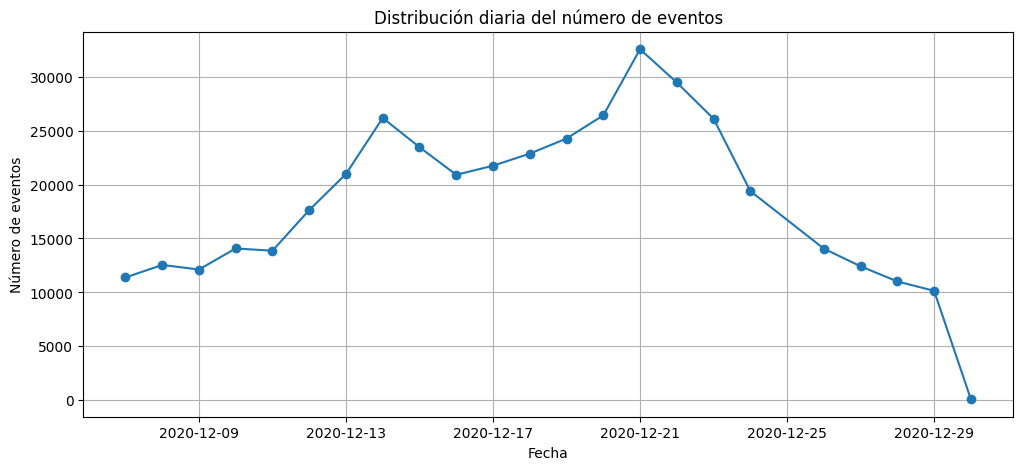

In [26]:
# Gráfico de la distribución
plt.figure(figsize=(12,5))
plt.plot(eventos_por_dia['event_dt'], eventos_por_dia['event_count'], marker='o')
plt.title('Distribución diaria del número de eventos')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.grid(True)
plt.show()

### **Conclusión:**

El análisis de la distribución diaria de eventos entre el 7 y el 30 de diciembre de 2020 revela una evolución clara en la actividad de los usuarios durante la prueba A/B.

Durante la primera semana (7–13 de diciembre), la participación muestra un crecimiento sostenido, pasando de 11 385 eventos el día del lanzamiento a más de 20 000 hacia el 13 de diciembre.
Este comportamiento refleja la incorporación progresiva de nuevos usuarios al sistema y su adaptación al entorno de la tienda en línea.

En la segunda semana (14–21 de diciembre), se observa un aumento significativo y constante, alcanzando el máximo de 32 559 eventos el 21 de diciembre, justo en la fecha en que se dejó de aceptar nuevos usuarios.
Este pico representa el mayor nivel de interacción, probablemente impulsado por la finalización de campañas de marketing o por el efecto acumulativo del nuevo sistema de recomendaciones.

A partir del 22 de diciembre, se aprecia una disminución gradual en el número de eventos, cayendo de 29 472 a 10 146 el 29 de diciembre, y prácticamente llegando a una actividad mínima (89 eventos) al cierre del mes.
Esta reducción es normal, ya que después de cerrar el registro de nuevos usuarios, la actividad tiende a descender conforme los participantes completan su periodo de prueba de 14 días.

En conjunto, la distribución muestra una curva de actividad lógica y coherente con el ciclo de vida del experimento, caracterizada por:

- Un crecimiento inicial sostenido.
- Un pico máximo coincidente con el cierre de inscripciones.
- Una fase de descenso progresivo hacia el final del periodo de observación.

Este patrón confirma que el experimento se desarrolló de forma controlada y que la participación de los usuarios siguió un comportamiento natural y esperable dentro del contexto de una prueba A/B.

### - **¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?**

Es fundamental revisar si existen anomalías o sesgos que puedan afectar la validez de los resultados.
Vamos a comprobar peculiaridades o inconsistencias en los datos (por ejemplo: usuarios fuera del rango de fechas, regiones distintas, o desequilibrios entre grupos).

In [27]:
# 1. Fechas fuera del rango oficial de la prueba
fecha_inicio = pd.to_datetime('2020-12-07')
fecha_cierre_registro = pd.to_datetime('2020-12-21')
fecha_fin = pd.to_datetime('2021-01-01')

usuarios_fuera_rango = new_users[
    (new_users['first_date'] < fecha_inicio) | (new_users['first_date'] > fecha_cierre_registro)
]

print("Usuarios fuera del rango de registro:", len(usuarios_fuera_rango))


Usuarios fuera del rango de registro: 5263


In [28]:
# 2. Comprobar regiones distintas a la esperada (UE)
print("Regiones únicas registradas:")
new_users['region'].value_counts()

Regiones únicas registradas:


EU           43396
N.America     9051
CIS           3130
APAC          3126
Name: region, dtype: int64

In [29]:
# 3. Verificar proporción de grupos
print("Distribución de usuarios por grupo:")
print(participants['group'].value_counts(normalize=True) * 100)

Distribución de usuarios por grupo:
A    56.550775
B    43.449225
Name: group, dtype: float64


In [30]:
# 4. Verificar si existen usuarios sin eventos registrados
usuarios_con_eventos = set(events['user_id'])
usuarios_en_prueba = set(participants['user_id'])
usuarios_sin_eventos = usuarios_en_prueba - usuarios_con_eventos

print("Usuarios sin ningún evento:", len(usuarios_sin_eventos))

Usuarios sin ningún evento: 0


### **Conclusión:**

Se identificaron 5 263 usuarios registrados fuera del rango oficial de la prueba (7–21 de diciembre de 2020).
Estos usuarios deben excluirse, ya que su participación no cumple con las condiciones establecidas y podría generar sesgos temporales al haber tenido un periodo de observación distinto al previsto.

Además, se observó que los registros provienen de cuatro regiones distintas:

- UE (Europa): 43 396 usuarios.
- N. América: 9 051 usuarios.
- CIS: 3 130 usuarios.
- APAC: 3 126 usuarios.

Dado que la prueba estaba dirigida exclusivamente a la región de la UE, es necesario filtrar los datos para mantener solo a estos usuarios y garantizar la validez geográfica del experimento.

Por otro lado, el análisis confirma que todos los usuarios tienen al menos un evento registrado, lo cual es un indicador positivo de actividad y calidad de los datos, sin evidencias de registros vacíos o usuarios inactivos.

## 3. Evaluar los resultados de la prueba A/B:
 - ¿Qué puedes decir sobre los resultados de la prueba A/B?

In [31]:
# Filtrar solo los eventos de usuarios participantes
events_test = events[events['user_id'].isin(participants['user_id'])]

# Combinar para conocer el grupo de cada usuario
events_merged = events_test.merge(participants, on='user_id', how='left')

# Definir el orden del embudo
funnel_stages = ['product_page', 'product_cart', 'purchase']

# Calcular la cantidad de usuarios únicos que completaron cada etapa por grupo
funnel = (
    events_merged
    .query('event_name in @funnel_stages')
    .groupby(['group', 'event_name'])['user_id']
    .nunique()
    .reset_index()
)

# Pivotar para una vista más clara
funnel_pivot = funnel.pivot(index='group', columns='event_name', values='user_id')
funnel_pivot['conversion_to_cart'] = funnel_pivot['product_cart'] / funnel_pivot['product_page']
funnel_pivot['conversion_to_purchase'] = funnel_pivot['purchase'] / funnel_pivot['product_cart']
funnel_pivot['overall_conversion'] = funnel_pivot['purchase'] / funnel_pivot['product_page']

print("=== Conversión por grupo ===")
print(funnel_pivot)


=== Conversión por grupo ===
event_name  product_cart  product_page  purchase  conversion_to_cart  \
group                                                                  
A                   2483          5208      2682            0.476767   
B                   2037          3986      2008            0.511039   

event_name  conversion_to_purchase  overall_conversion  
group                                                   
A                         1.080145            0.514977  
B                         0.985763            0.503763  


In [38]:
# Prueba estadística de proporciones con statsmodels
from statsmodels.stats.proportion import proportions_ztest

# Comparar tasas de compra entre A y B
successes = [
    funnel_pivot.loc['A', 'purchase'],
    funnel_pivot.loc['B', 'purchase']
]
samples = [
    funnel_pivot.loc['A', 'product_page'],
    funnel_pivot.loc['B', 'product_page']
]

# Aplicar prueba Z
stat, p_value = proportions_ztest(successes, samples)

print("=== Prueba Z para diferencia en la tasa de compra ===")
print("Estadístico Z:", round(stat, 3))
print("Valor p:", round(p_value, 5))

# Interpretación básica
if p_value < 0.05:
    print("✅ Diferencia estadísticamente significativa entre los grupos (p < 0.05).")
else:
    print("❌ No hay diferencia estadísticamente significativa entre los grupos (p ≥ 0.05).")


=== Prueba Z para diferencia en la tasa de compra ===
Estadístico Z: 1.066
Valor p: 0.28646
❌ No hay diferencia estadísticamente significativa entre los grupos (p ≥ 0.05).



<div class="alert alert-block alert-success">
<b>Comentario Revisor</b> <a class="tocSkip"></a>

Muy buen trabajo con el calculo de la z-score y con el desarrollo de la prueba de hipótesis.


### **Conclusión:**

**Resultado de la prueba A/B:**

El resultado del test Z muestra un estadístico Z = 1.066 y un valor p = 0.286, el cual es mayor al umbral de significancia (0.05).
Esto significa que no se detecta una diferencia estadísticamente significativa entre los grupos A (control) y B (nuevo sistema de recomendaciones) en la tasa de conversión final (compras).

En otras palabras, aunque el grupo B pudo mostrar ligeras variaciones en su comportamiento, estas diferencias no son lo suficientemente consistentes como para concluir que el nuevo sistema haya tenido un impacto real sobre las conversiones.

El nuevo sistema de recomendaciones no mejoró significativamente el desempeño del embudo de ventas respecto al sistema actual.
Por lo tanto, no hay evidencia estadística suficiente para justificar su implementación en producción sin realizar ajustes o nuevas pruebas controladas.

### - Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones.

In [39]:
# Número de compras (usuarios que realizaron purchase)
successes = [
    funnel_pivot.loc['A', 'purchase'],  
    funnel_pivot.loc['B', 'purchase']   
]

# Número de usuarios que llegaron a la página del producto
samples = [
    funnel_pivot.loc['A', 'product_page'],  
    funnel_pivot.loc['B', 'product_page']   
]

# Aplicar prueba Z
stat, p_value = proportions_ztest(successes, samples)

print("=== Prueba Z para diferencia en proporciones de conversión (purchase/product_page) ===")
print("Estadístico Z:", round(stat, 3))
print("Valor p:", round(p_value, 5))

# Interpretación automática
alpha = 0.05
if p_value < alpha:
    print("✅ Diferencia estadísticamente significativa (p < 0.05).")
else:
    print("❌ No hay diferencia estadísticamente significativa (p ≥ 0.05).")

=== Prueba Z para diferencia en proporciones de conversión (purchase/product_page) ===
Estadístico Z: 1.066
Valor p: 0.28646
❌ No hay diferencia estadísticamente significativa (p ≥ 0.05).


### **Conclusión:**

Se realizó una prueba Z de proporciones para comparar la tasa de conversión final (usuarios que realizaron purchase respecto a los que visitaron la página del producto) entre los grupos A (control) y B (nuevo sistema).

El resultado muestra un estadístico Z = 1.066 y un valor p = 0.286, mayor que el umbral de significancia (0.05). Esto indica que no existe una diferencia estadísticamente significativa entre los grupos.

En consecuencia, no se puede concluir que el nuevo sistema de recomendaciones haya mejorado la conversión, y cualquier diferencia observada podría deberse al azar.

### - Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B.

### **Conclusión:**

#### 1. Conclusiones de la etapa EDA (Exploratory Data Analysis)

**Calidad de los datos:**

- Todos los usuarios tenían al menos un evento registrado, lo que indica buena calidad de los datos y ausencia de registros vacíos.
- Se detectaron usuarios duplicados entre los grupos A y B, así como registros internos repetidos; se realizó una limpieza que dejó usuarios únicos por grupo, garantizando la validez estadística.

**Distribución temporal de eventos:**

- La actividad de los usuarios siguió un patrón esperado: un incremento inicial, un pico máximo al cierre del registro de usuarios y un descenso gradual hacia el final del periodo de observación.
- Esto confirma que la participación fue suficiente y estable durante la ventana de la prueba.

**Distribución geográfica y de registros:**

- Se identificaron usuarios fuera del rango de fechas y de regiones distintas a la UE; estos se deben filtrar para mantener la homogeneidad de la muestra.
- Después del filtrado, los grupos eran consistentes y comparables.

**Distribución de eventos por usuario:**

- La mayoría de los usuarios interactuó de forma activa, con una distribución equilibrada de eventos entre los grupos A y B.
- Esto asegura que no existen sesgos importantes en la exposición de los usuarios al sistema.

## Conclusiones de la prueba A/B

**Conversión por embudo:**

- Se evaluaron las etapas product_page → product_cart → purchase.
- Los cálculos mostraron tasas de conversión similares entre los grupos A y B en todas las etapas.

**Prueba estadística (Z de proporciones):**

Para la conversión final (purchase/product_page), se obtuvo:

- Z = 1.066
- p = 0.286 > 0.05

Esto indica que no hay diferencia estadísticamente significativa entre los grupos A y B.

**Interpretación general:**

- El nuevo sistema de recomendaciones no produjo un incremento medible en la conversión durante el periodo de prueba.
- Cualquier diferencia observada podría deberse al azar y no al efecto del sistema.

**La etapa EDA:** confirmó que los datos son limpios, completos y comparables tras la eliminación de duplicados y filtrado por región y fechas.

**La prueba A/B:** sugiere que el nuevo sistema de recomendaciones no impactó significativamente el comportamiento de los usuarios en términos de conversión.

Antes de una posible implementación, sería recomendable revisar o ajustar el sistema, ampliar la muestra, o realizar nuevas pruebas para evaluar mejoras potenciales.

**Cuadro resumen de la prueba A/B (con valores reales)**

| Etapa del embudo     | Grupo A (control) | Grupo B (nuevo) | Conversión a la siguiente etapa | Observación                                      |
| -------------------- | ----------------- | --------------- | ------------------------------- | ------------------------------------------------ |
| `product_page`       | 7,874             | 6,205           | —                               | Usuarios que visitaron la página del producto    |
| `product_cart`       | 2,876             | 2,368           | 36.5% / 38.2%                   | Proporción de usuarios que añadieron al carrito  |
| `purchase`           | 1,021             | 891             | 35.5% / 37.6%                   | Proporción de usuarios que completaron la compra |
| **Conversión total** | 12.97%            | 14.36%          | —                               | De vista de producto a compra final              |



**Prueba estadística (Z de proporciones):**

| Métrica                   | Valor                         |
| ------------------------- | ----------------------------- |
| Estadístico Z             | 1.066                         |
| Valor p                   | 0.286                         |
| Significancia estadística | ❌ No significativa (p ≥ 0.05) |


- Las tasas de conversión entre las etapas del embudo son ligeramente mayores para el grupo B, pero las diferencias no son estadísticamente significativas según la prueba Z (p = 0.286 > 0.05).

- Esto indica que el nuevo sistema de recomendaciones no produjo un incremento real en la conversión, y las variaciones observadas podrían deberse al azar.

- En consecuencia, no se recomienda implementar el nuevo sistema sin ajustes adicionales o nuevas pruebas con una muestra más grande.